# Analytic spiral

We create a Magritte model form an analytic description of an Archimedean spiral outflow.
The description of the model is based on [Homan et al. (2015)](https://www.aanda.org/articles/aa/full_html/2015/07/aa25933-15/aa25933-15.html).

## Setup

Import the required functionalty.

In [1]:
import magritte.setup    as setup                      # Model setup
import magritte.core     as magritte                   # Core functionality
import magritte.mesher   as mesher                     # Mesher
import numpy             as np                         # Data structures
import meshio
import warnings                                        # Hide warnings
warnings.filterwarnings('ignore')                      # especially for yt
import yt                                              # 3D plotting

from tqdm                   import tqdm                # Progress bars
from astropy                import units, constants    # Unit conversions
from scipy.spatial          import Delaunay, cKDTree   # Finding neighbors
from yt.funcs               import mylog               # To avoid yt output 
mylog.setLevel(40)                                     # as error messages

Define a working directory (you will have to change this).

In [2]:
wdir = "/home/frederik/Magritte-examples/Analytic_spiral/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
model_file = f'{wdir}model_analytic_spiral.hdf5'   # Resulting Magritte model
lamda_file = f'{wdir}co.txt'                       # Line data file
bmesh_name = f'{wdir}analytic_spiral'              # bachground mesh name (no extension!)

We use a snapshot and data file that can be downloaded with the following links.

In [5]:
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $lamda_link --output-document $lamda_file

## Spiral parameters

The functions below describe the spiral structure, based on the parameters in [Homan et al. (2015)](https://www.aanda.org/articles/aa/full_html/2015/07/aa25933-15/aa25933-15.html).

In [7]:
phi_0 =   0 / 180.0 * np.pi                         # [radian]
alpha =  15 / 180.0 * np.pi                         # [radian]
sigma =  20               * constants.au.si.value   # [m]
b     = 270 / (2.0*np.pi) * constants.au.si.value   # [m]


def r_0(r, theta, phi):
    return b*(phi - phi_0)


def sigma_r(r, theta, phi):
    return sigma


def theta_0(r, theta, phi):
    return 0.5*np.pi


def sigma_theta(r, theta, phi):
    return alpha


def S(r, theta, phi):
    rd = (r     - r_0    (r,theta,phi)) / sigma_r    (r,theta,phi)
    td = (theta - theta_0(r,theta,phi)) / sigma_theta(r,theta,phi)
    return np.exp(-0.5*(rd**2 + td**2))


def SS(r, theta, phi):
    result = 0.0
    for i in range(10):
        result += S(r, theta, phi+2.0*np.pi*i)
    return result

## Physical parameters

In [8]:
R_max   = 600.0 * constants.au.si.value                    # [m]
R_star  =   1.0 * constants.R_sun.si.value                 # [m]
v_inf   = 14.5e+3                                          # [m/s]
beta    = 0.4                                              # [.]
Mdot    = 1.5e-6 * (constants.M_sun/units.year).si.value   # [kg/s]
R_0     = 2.0 * R_star                                     # [m]
epsilon = 0.5                                              # [.]
T_star  = 2330.0                                           # [K]
T_0     = 60.0                                             # [K]
rho_max = 1.0e-11                                          # [kg/m^3]


def v_r(r):
    return v_inf * (1.0 - R_0/r)**beta


def rho_regular(r):
    return Mdot / (4.0*np.pi*r**2*v_r(r))


def rho_spiral(r, theta, phi):
    return rho_max * (2.0*np.pi*b/r)**2 * SS(r, theta, phi)


def rho_wind(r, theta, phi):
    return rho_regular(r) + rho_spiral(r, theta, phi)


def T_HO(r):
    return T_star * (R_star/r)**epsilon


def T_spiral(r, theta, phi):
    return T_0 * SS(r, theta, phi)


def T_wind(r, theta, phi):
    return T_HO(r) + T_spiral(r, theta, phi)

In [9]:
def spherical(x,y,z):
    r = np.sqrt   (x**2 + y**2 + z**2)
    t = np.arccos (z/r)
    p = np.arctan2(y,x)
    return (r,t,p)

## Create background mesh (with desired mesh element sizes)

Define the desired mesh element size in a ($100 \times 100 \times 100$) cube.

In [10]:
resolution = 100

xs = np.linspace(-R_max, +R_max, resolution, endpoint=True)
ys = np.linspace(-R_max, +R_max, resolution, endpoint=True)
zs = np.linspace(-R_max, +R_max, resolution, endpoint=True)

(Xs, Ys, Zs) = np.meshgrid(xs, ys, zs)

position = np.array((Xs.ravel(), Ys.ravel(), Zs.ravel())).T

# Compute the corresponding spherical coordinates
Rs = np.sqrt   (Xs**2 + Ys**2 + Zs**2)
Ts = np.arccos (Zs/Rs)
Ps = np.arctan2(Ys,Xs)

# Evaluate the density on the cube
rhos = rho_wind(Rs, Ts, Ps)
rhos = np.nan_to_num(rhos, nan=1.0)

In [11]:
# Define min and max desired mesh element size (= scale)
scale_min = 15.0 * constants.au.si.value
scale_max = 50.0 * constants.au.si.value

weights = np.linalg.norm(np.gradient(np.log(rhos)), axis=0)

# Determine the upper and lower promile quantile
w_min = np.quantile(weights, 0.001)
w_max = np.quantile(weights, 0.999)

# 
weights[weights < w_min] = w_min
weights[weights > w_max] = w_max

# Linearly scale desired mesh elemen with the weights
weights = (scale_min - scale_max) * (weights - w_min) / (w_max - w_min) + scale_max

No we can create a mesh using the `weights` as desired elemenst sizes.
First, create a Delaunay mesh for the cube. (Might take a while!)

In [12]:
delaunay = Delaunay(position)

Write out the background mesh in .msh format (`%%capture` suppresses the output).

In [13]:
%%capture
meshio.write_points_cells(
    filename   = f'{bmesh_name}.msh',
    points     = position,
    cells      = {'tetra'  : delaunay.simplices},
    point_data = {'weights': weights.ravel()} )

Convert .msh to .pos mesh format for Gmsh.

In [14]:
%%capture
mesher.convert_msh_to_pos (f'{bmesh_name}.msh', replace=True)

Create a new mesh from the background mesh.

In [15]:
%%capture
mesher.create_mesh_from_background(
    meshName  = f'{bmesh_name}.msh',
    boundary  = mesher.boundary_sphere(radius=R_max),
    scale_min = scale_min,
    scale_max = scale_max )

Load the reducded mesh created above (a `.vtk` file with the same name as `bmesh_name`).

In [16]:
%%capture
mesh = mesher.Mesh(f'{bmesh_name}.vtk')

In [17]:
npoints = len(mesh.points)

XCO   = 6.0e-4   # [.]
vturb = 1.5e+3   # [m/s]


def density(rr):
    (r, t, p) = spherical(rr[0], rr[1], rr[2])
    return rho_wind(r, t, p)


def abn_nH2(rr):
    return density(rr) * (constants.N_A.si.value) / (2.01588 * constants.u.si.value)


def abn_nCO(rr):
    return XCO * abn_nH2(rr)


def temp(rr):
    (r, t, p) = spherical(rr[0], rr[1], rr[2])
    return T_wind(r, t, p)

        
def turb(rr):
    return (vturb/constants.c.si.value)**2


def velo(rr):
    (r, t, p) = spherical(rr[0], rr[1], rr[2])
    return v_r(r) * np.array([rr[0], rr[1], rr[2]]) / r


# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(mesh.points)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

In [18]:
position = mesh.points
velocity = np.array([velo   (rr) for rr in mesh.points])
nH2      = np.array([abn_nH2(rr) for rr in mesh.points])
nCO      = np.array([abn_nCO(rr) for rr in mesh.points])
tmp      = np.array([temp   (rr) for rr in mesh.points])
trb      = np.array([turb   (rr) for rr in mesh.points])

## Create model

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [19]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_spherical_symmetry (False)        # No spherical symmetry
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (npoints)      # Number of points
model.parameters.set_nrays              (12)           # Number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (31)           # Number of quadrature points
model.parameters.set_pop_prec           (1.0e-6)       # Pops. convergence criterion

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!


## Plot model

Load the data in a `yt` unstructured mesh.

In [20]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis and x-axis.


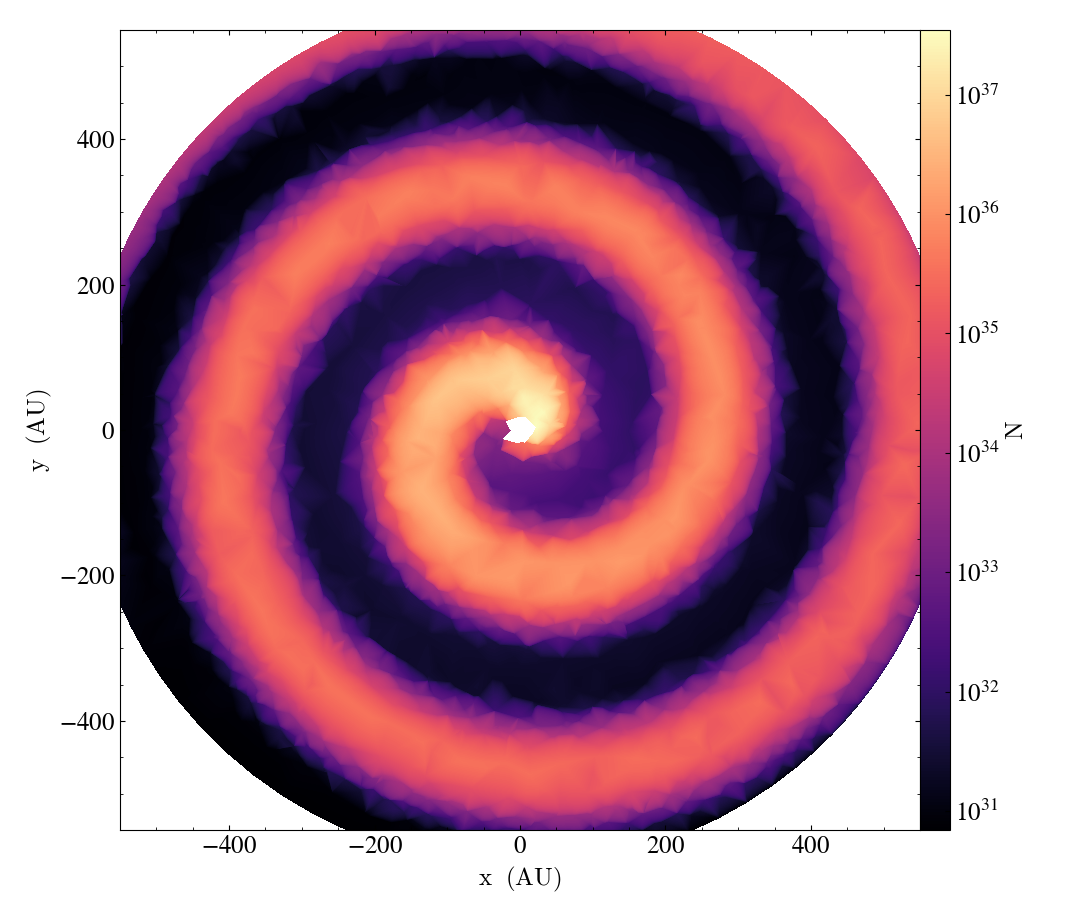

In [21]:
sl = yt.SlicePlot (ds, 'z', 'n')
sl.set_cmap       ('n', 'magma')
sl.zoom           (1.2)


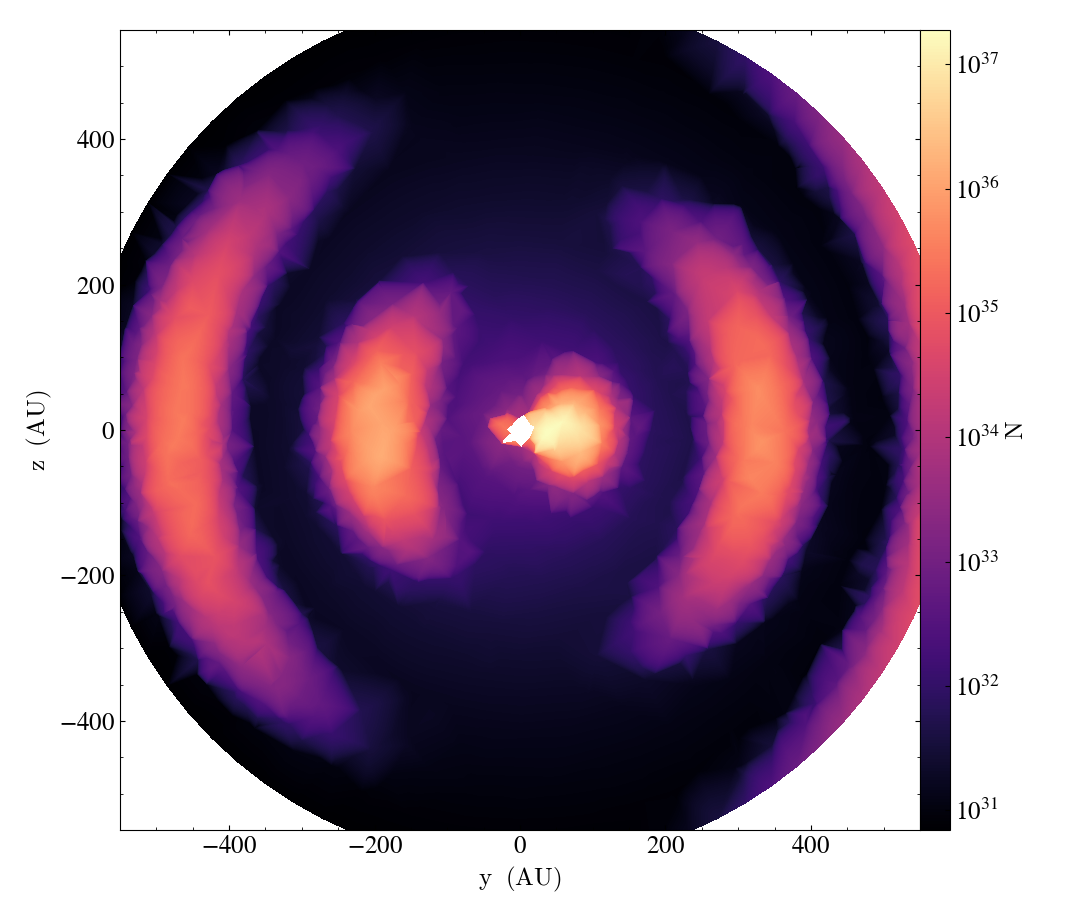

In [23]:
sl = yt.SlicePlot (ds, 'x', 'n')
sl.set_cmap       ('n', 'magma')
sl.zoom           (1.2)

Show meshes on the plots.


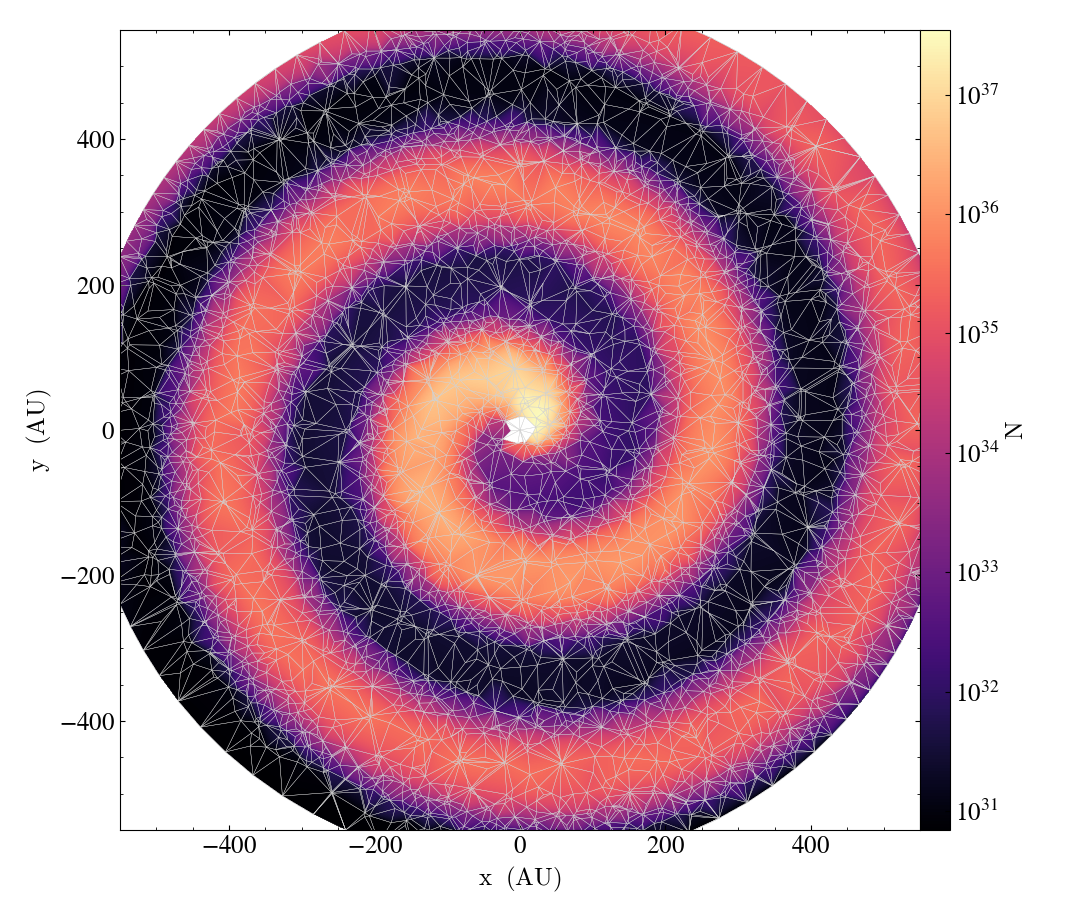

In [22]:
sl = yt.SlicePlot      (ds, 'z', 'n')
sl.set_cmap            ('n', 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


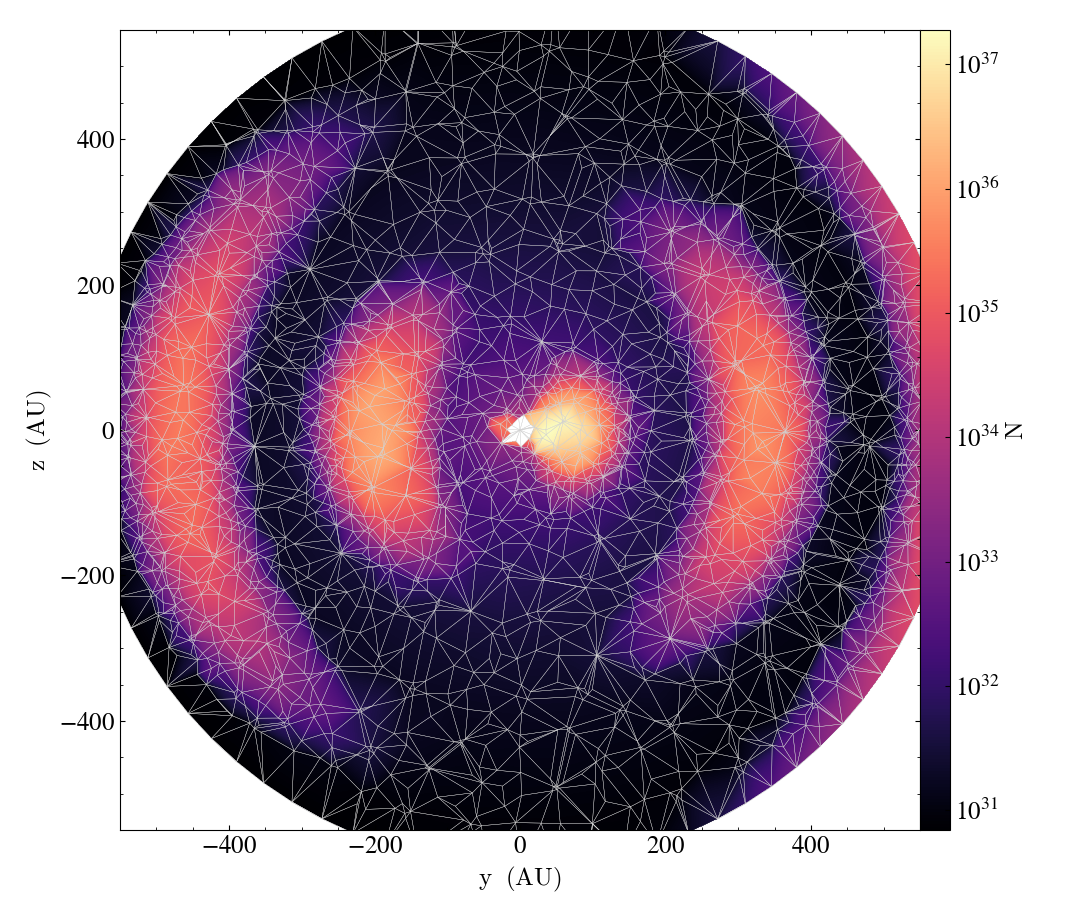

In [24]:
sl = yt.SlicePlot      (ds, 'x', 'n')
sl.set_cmap            ('n', 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})